In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random, torch

random.seed(0) # Set seed for NumPy
np.random.seed(0) # Set seed for PyTorch (for both CPU and GPU)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [ ]:
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [ ]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [ ]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor, and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])

class Dataset():
    """
    This class is to read the data and pass an instance of it later to the Dataloader
    """
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [ ]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8
#replacing the last fc in the pretrained base model
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True

loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)


/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
import numpy as np
class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        self.pool_features = []
        self.pool_indices = []
        # self.best_acc = 0

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        # auto_encoder =  Autoencoder(256)
        # auto_encoder.load_state_dict(torch.load('vae_model.pth'))
        self._get_features()
        for iteration in range(self.iterations):
            # if len(self.train_indices) > 600:
            #     # raise error if the train set is larger than 600 samples
            #     raise ValueError('The train set is larger than 600 samples')
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'kmeans_budget':
                self._kmeans_sampling()
            else:
              self._custom_sampling(iteration)

            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            #loading the best model weights on the validation set in each iteration
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def calculate_class_weights(self, label_counts, num_classes=8):
        """
        Calculating the inverse of the probability of each class in the dataset
        """
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)

        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch

        return class_weights

    def _train_model(self, train_images, label_df):
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      loss_f = nn.CrossEntropyLoss(weight=class_weights)

      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
                #saving the best model on the validation
                val_acc = self._check_model()
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)

    def _check_model(self):
        """
        Evaluating the model on the validation set
        """
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()

    def _evaluate_model(self):
        """
        Evaluate the model on the test set
        :return:
        accuracy: float, accuracy of the model
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)

    def extract_vae_features(self, dataloader, model, feature_extractor):
        """
        Extracting the Representation of the images as a victor based on the feature_extractor which is the embedding model
        return the victors of the images we extracted and the indices
        """
        features_list = []
        indices_list = []

        with torch.no_grad():
            for images, indices in dataloader:
                images = images.to(device)  # Move images to GPU if available
                images_list = [transforms.ToPILImage()(img) for img in images]
                inputs = feature_extractor(images=images_list, return_tensors="pt")
                inputs = inputs.to(device)
                with torch.no_grad():
                    outputs = model(**inputs)

                x = outputs.last_hidden_state[:, 0, :]
                features_list.append(x.cpu().numpy())

                # Collect indices
                indices_list.extend(indices)

        # Stack all features into a 2D array (n_samples, hidden_dim)
        features = np.vstack(features_list)

        return features, indices_list


    def get_representative_images(self, kmeans, pool_features, pool_indices):
        """
         returns a dictionary where the keys are the index of the cluster and the values are the closest images to
         each centroid note that the K of the KMeans is the budget per iteration.
        """
        cluster_to_images = {}
        for i in range(kmeans.n_clusters):
            # Get the indices of all images in the current cluster
            cluster_indices = np.where(kmeans.labels_ == i)[0]

            # Extract features of the images in the current cluster
            cluster_features = pool_features[cluster_indices]

            # Compute distances between each feature and the cluster centroid
            distances = np.linalg.norm(cluster_features - kmeans.cluster_centers_[i], axis=1)

            # Map the cluster number to the index of the representative image
            nearest_indices = cluster_indices[np.argsort(distances)[:1]]

            # Map the cluster number to the indices of the top k nearest images
            cluster_to_images[i] = [pool_indices[idx] for idx in nearest_indices]

        return cluster_to_images

    def _get_features(self):
        #loading the pretrained Vit model to get images embeddings
        feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        model = model.to(device)

        X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]
        # Extract latent features using the Vit model
        pool_images_tensor = torch.stack(X_unlabeled)
        pool_indices_tensor = torch.tensor(self.available_pool_indices)
        pool_dataset = TensorDataset(pool_images_tensor, pool_indices_tensor)

        batch_size = 32
        pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)

        self.pool_features, self.pool_indices = self.extract_vae_features(pool_loader, model, feature_extractor)

    def _kmeans_sampling(self):
          n_clusters = self.budget_per_iter
          kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
          kmeans.fit(self.pool_features)

          representative_images = self.get_representative_images(kmeans, self.pool_features, self.pool_indices)
          selected_indices = list(ids.item() for l in representative_images.values() for ids in l)

          for i in selected_indices:
              index = self.pool_indices.index(i)
              self.pool_features = np.delete(self.pool_features, index, axis=0)
              self.pool_indices.pop(index)
          self.train_indices = self.train_indices + selected_indices

          available_pool_set = set(self.available_pool_indices)
          train_set = set(self.train_indices)
          self.available_pool_indices = list(available_pool_set - train_set)


In [ ]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
available_pool_indices = []
for i in range(len(train_df)):
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
    image, label, index = test_df[i]
    test_indices.append(index)
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [ ]:
#According to the initialization that we got using KMeans++ Code of the initialization could be found in the initials file.
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [ ]:
iterations = 20
budget_per_iter = 60
num_epoch = 15
selection_criteria = ['kmeans_budget']
accuracy_scores_dict = defaultdict(list)
model = base_model

2024-10-16 17:29:14.382560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 17:29:14.654865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-10-16 17:29:14.654936: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cud

--------- Number of Iteration 0 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0904, Accuracy: 0.0889


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 2.0600, Accuracy: 0.2889
Epoch [3/15], Loss: 2.0226, Accuracy: 0.4444
Epoch [4/15], Loss: 1.9662, Accuracy: 0.4889
Epoch [5/15], Loss: 1.8840, Accuracy: 0.6444
Epoch [6/15], Loss: 1.8495, Accuracy: 0.4889
Epoch [7/15], Loss: 1.7900, Accuracy: 0.4778
Epoch [8/15], Loss: 1.7278, Accuracy: 0.5222
Epoch [9/15], Loss: 1.6565, Accuracy: 0.7222
Epoch [10/15], Loss: 1.6248, Accuracy: 0.7333
Epoch [11/15], Loss: 1.5672, Accuracy: 0.8222
Epoch [12/15], Loss: 1.5571, Accuracy: 0.8333
Epoch [13/15], Loss: 1.5124, Accuracy: 0.8667
Epoch [14/15], Loss: 1.4906, Accuracy: 0.8889
Epoch [15/15], Loss: 1.4616, Accuracy: 0.9111
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.7010, Accuracy: 0.7133


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6895, Accuracy: 0.7467
Epoch [3/15], Loss: 1.6661, Accuracy: 0.7600
Epoch [4/15], Loss: 1.6367, Accuracy: 0.7400
Epoch [5/15], Loss: 1.6026, Accuracy: 0.7933
Epoch [6/15], Loss: 1.5980, Accuracy: 0.7933
Epoch [7/15], Loss: 1.5620, Accuracy: 0.8000
Epoch [8/15], Loss: 1.5557, Accuracy: 0.7933
Epoch [9/15], Loss: 1.5146, Accuracy: 0.8267
Epoch [10/15], Loss: 1.5154, Accuracy: 0.8533
Epoch [11/15], Loss: 1.4863, Accuracy: 0.8467
Epoch [12/15], Loss: 1.4857, Accuracy: 0.8467
Epoch [13/15], Loss: 1.4758, Accuracy: 0.8533
Epoch [14/15], Loss: 1.4841, Accuracy: 0.8467
Epoch [15/15], Loss: 1.4482, Accuracy: 0.8533
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 2 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5779, Accuracy: 0.7619


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5735, Accuracy: 0.7619
Epoch [3/15], Loss: 1.5459, Accuracy: 0.8048
Epoch [4/15], Loss: 1.5301, Accuracy: 0.7905
Epoch [5/15], Loss: 1.5580, Accuracy: 0.8238
Epoch [6/15], Loss: 1.4967, Accuracy: 0.8238
Epoch [7/15], Loss: 1.5033, Accuracy: 0.7952
Epoch [8/15], Loss: 1.4956, Accuracy: 0.8619
Epoch [9/15], Loss: 1.4605, Accuracy: 0.8333
Epoch [10/15], Loss: 1.4634, Accuracy: 0.8381
Epoch [11/15], Loss: 1.4567, Accuracy: 0.8476
Epoch [12/15], Loss: 1.4608, Accuracy: 0.8143
Epoch [13/15], Loss: 1.4595, Accuracy: 0.8333
Epoch [14/15], Loss: 1.4563, Accuracy: 0.8619
Epoch [15/15], Loss: 1.4477, Accuracy: 0.8571
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 3 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5298, Accuracy: 0.8037


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5505, Accuracy: 0.7704
Epoch [3/15], Loss: 1.5185, Accuracy: 0.8185
Epoch [4/15], Loss: 1.5148, Accuracy: 0.8185
Epoch [5/15], Loss: 1.5323, Accuracy: 0.7815
Epoch [6/15], Loss: 1.4797, Accuracy: 0.8259
Epoch [7/15], Loss: 1.4709, Accuracy: 0.8667
Epoch [8/15], Loss: 1.5007, Accuracy: 0.8185
Epoch [9/15], Loss: 1.4579, Accuracy: 0.8444
Epoch [10/15], Loss: 1.4556, Accuracy: 0.8667
Epoch [11/15], Loss: 1.4571, Accuracy: 0.8667
Epoch [12/15], Loss: 1.4223, Accuracy: 0.8889
Epoch [13/15], Loss: 1.4585, Accuracy: 0.8667
Epoch [14/15], Loss: 1.4321, Accuracy: 0.8889
Epoch [15/15], Loss: 1.4489, Accuracy: 0.8741
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 4 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4836, Accuracy: 0.8394


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4817, Accuracy: 0.8424
Epoch [3/15], Loss: 1.4972, Accuracy: 0.8152
Epoch [4/15], Loss: 1.5168, Accuracy: 0.8303
Epoch [5/15], Loss: 1.5065, Accuracy: 0.7970
Epoch [6/15], Loss: 1.4770, Accuracy: 0.8515
Epoch [7/15], Loss: 1.4641, Accuracy: 0.8636
Epoch [8/15], Loss: 1.4431, Accuracy: 0.8545
Epoch [9/15], Loss: 1.4174, Accuracy: 0.8364
Epoch [10/15], Loss: 1.4142, Accuracy: 0.8667
Epoch [11/15], Loss: 1.4227, Accuracy: 0.8364
Epoch [12/15], Loss: 1.4119, Accuracy: 0.8636
Epoch [13/15], Loss: 1.4221, Accuracy: 0.8576
Epoch [14/15], Loss: 1.4159, Accuracy: 0.8303
Epoch [15/15], Loss: 1.3859, Accuracy: 0.8667
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 5 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4805, Accuracy: 0.8077


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5175, Accuracy: 0.8128
Epoch [3/15], Loss: 1.4584, Accuracy: 0.7769
Epoch [4/15], Loss: 1.4641, Accuracy: 0.8205
Epoch [5/15], Loss: 1.4540, Accuracy: 0.8205
Epoch [6/15], Loss: 1.4345, Accuracy: 0.8128
Epoch [7/15], Loss: 1.4226, Accuracy: 0.8513
Epoch [8/15], Loss: 1.4483, Accuracy: 0.7974
Epoch [9/15], Loss: 1.4785, Accuracy: 0.8308
Epoch [10/15], Loss: 1.4344, Accuracy: 0.8205
Epoch [11/15], Loss: 1.4090, Accuracy: 0.8692
Epoch [12/15], Loss: 1.4135, Accuracy: 0.8487
Epoch [13/15], Loss: 1.3855, Accuracy: 0.8667
Epoch [14/15], Loss: 1.4437, Accuracy: 0.8538
Epoch [15/15], Loss: 1.4062, Accuracy: 0.8590
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 6 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6306, Accuracy: 0.6489


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6101, Accuracy: 0.7200
Epoch [3/15], Loss: 1.5364, Accuracy: 0.7356
Epoch [4/15], Loss: 1.5424, Accuracy: 0.7333
Epoch [5/15], Loss: 1.5064, Accuracy: 0.7267
Epoch [6/15], Loss: 1.4905, Accuracy: 0.7289
Epoch [7/15], Loss: 1.5587, Accuracy: 0.7178
Epoch [8/15], Loss: 1.4780, Accuracy: 0.7422
Epoch [9/15], Loss: 1.4483, Accuracy: 0.8244
Epoch [10/15], Loss: 1.4482, Accuracy: 0.7867
Epoch [11/15], Loss: 1.4856, Accuracy: 0.7733
Epoch [12/15], Loss: 1.4659, Accuracy: 0.8289
Epoch [13/15], Loss: 1.4889, Accuracy: 0.7511
Epoch [14/15], Loss: 1.5040, Accuracy: 0.7489
Epoch [15/15], Loss: 1.4614, Accuracy: 0.8200
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 7 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4762, Accuracy: 0.7431


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4705, Accuracy: 0.7824
Epoch [3/15], Loss: 1.4358, Accuracy: 0.7824
Epoch [4/15], Loss: 1.4222, Accuracy: 0.8078
Epoch [5/15], Loss: 1.4557, Accuracy: 0.7941
Epoch [6/15], Loss: 1.4110, Accuracy: 0.8275
Epoch [7/15], Loss: 1.4169, Accuracy: 0.8078
Epoch [8/15], Loss: 1.4026, Accuracy: 0.8275
Epoch [9/15], Loss: 1.4017, Accuracy: 0.8431
Epoch [10/15], Loss: 1.3827, Accuracy: 0.8588
Epoch [11/15], Loss: 1.3792, Accuracy: 0.8490
Epoch [12/15], Loss: 1.3731, Accuracy: 0.8804
Epoch [13/15], Loss: 1.4156, Accuracy: 0.8196
Epoch [14/15], Loss: 1.3825, Accuracy: 0.8745
Epoch [15/15], Loss: 1.3946, Accuracy: 0.8412
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 8 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4558, Accuracy: 0.7965


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4425, Accuracy: 0.7930
Epoch [3/15], Loss: 1.4622, Accuracy: 0.7649
Epoch [4/15], Loss: 1.4131, Accuracy: 0.8333
Epoch [5/15], Loss: 1.4269, Accuracy: 0.7912
Epoch [6/15], Loss: 1.4295, Accuracy: 0.8193
Epoch [7/15], Loss: 1.4118, Accuracy: 0.8386
Epoch [8/15], Loss: 1.3976, Accuracy: 0.8456
Epoch [9/15], Loss: 1.4065, Accuracy: 0.8333
Epoch [10/15], Loss: 1.3949, Accuracy: 0.8456
Epoch [11/15], Loss: 1.4016, Accuracy: 0.8456
Epoch [12/15], Loss: 1.3882, Accuracy: 0.8526
Epoch [13/15], Loss: 1.3902, Accuracy: 0.8544
Epoch [14/15], Loss: 1.3883, Accuracy: 0.8614
Epoch [15/15], Loss: 1.3855, Accuracy: 0.8614
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 9 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4403, Accuracy: 0.8222


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4587, Accuracy: 0.7587
Epoch [3/15], Loss: 1.4514, Accuracy: 0.8079
Epoch [4/15], Loss: 1.4520, Accuracy: 0.7905
Epoch [5/15], Loss: 1.4242, Accuracy: 0.8127
Epoch [6/15], Loss: 1.4090, Accuracy: 0.8460
Epoch [7/15], Loss: 1.4209, Accuracy: 0.8206
Epoch [8/15], Loss: 1.4451, Accuracy: 0.8000
Epoch [9/15], Loss: 1.4186, Accuracy: 0.8159
Epoch [10/15], Loss: 1.4118, Accuracy: 0.8302
Epoch [11/15], Loss: 1.3990, Accuracy: 0.8476
Epoch [12/15], Loss: 1.4120, Accuracy: 0.8270
Epoch [13/15], Loss: 1.4040, Accuracy: 0.8333
Epoch [14/15], Loss: 1.3967, Accuracy: 0.8429
Epoch [15/15], Loss: 1.3943, Accuracy: 0.8492
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 10 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4973, Accuracy: 0.7623


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4774, Accuracy: 0.7971
Epoch [3/15], Loss: 1.4814, Accuracy: 0.7638
Epoch [4/15], Loss: 1.4570, Accuracy: 0.7797
Epoch [5/15], Loss: 1.4530, Accuracy: 0.7913
Epoch [6/15], Loss: 1.4479, Accuracy: 0.7884
Epoch [7/15], Loss: 1.4489, Accuracy: 0.8130
Epoch [8/15], Loss: 1.4443, Accuracy: 0.8014
Epoch [9/15], Loss: 1.4482, Accuracy: 0.8000
Epoch [10/15], Loss: 1.4465, Accuracy: 0.7870
Epoch [11/15], Loss: 1.4351, Accuracy: 0.8232
Epoch [12/15], Loss: 1.4353, Accuracy: 0.8087
Epoch [13/15], Loss: 1.4450, Accuracy: 0.8072
Epoch [14/15], Loss: 1.4504, Accuracy: 0.7826
Epoch [15/15], Loss: 1.4225, Accuracy: 0.8188
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 11 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4684, Accuracy: 0.7787


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4487, Accuracy: 0.7987
Epoch [3/15], Loss: 1.4403, Accuracy: 0.8093
Epoch [4/15], Loss: 1.4358, Accuracy: 0.8040
Epoch [5/15], Loss: 1.4320, Accuracy: 0.8120
Epoch [6/15], Loss: 1.4613, Accuracy: 0.7893
Epoch [7/15], Loss: 1.4320, Accuracy: 0.8173
Epoch [8/15], Loss: 1.4542, Accuracy: 0.7960
Epoch [9/15], Loss: 1.4160, Accuracy: 0.8307
Epoch [10/15], Loss: 1.4357, Accuracy: 0.8027
Epoch [11/15], Loss: 1.4400, Accuracy: 0.8027
Epoch [12/15], Loss: 1.4460, Accuracy: 0.8187
Epoch [13/15], Loss: 1.4484, Accuracy: 0.8147
Epoch [14/15], Loss: 1.4123, Accuracy: 0.8240
Epoch [15/15], Loss: 1.4254, Accuracy: 0.8240
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 12 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4422, Accuracy: 0.8025


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4545, Accuracy: 0.8074
Epoch [3/15], Loss: 1.4400, Accuracy: 0.8000
Epoch [4/15], Loss: 1.4502, Accuracy: 0.8000
Epoch [5/15], Loss: 1.4603, Accuracy: 0.8074
Epoch [6/15], Loss: 1.4581, Accuracy: 0.8012
Epoch [7/15], Loss: 1.4386, Accuracy: 0.8136
Epoch [8/15], Loss: 1.4463, Accuracy: 0.8123
Epoch [9/15], Loss: 1.4515, Accuracy: 0.7728
Epoch [10/15], Loss: 1.4552, Accuracy: 0.7988
Epoch [11/15], Loss: 1.4292, Accuracy: 0.8346
Epoch [12/15], Loss: 1.4229, Accuracy: 0.8259
Epoch [13/15], Loss: 1.4393, Accuracy: 0.8395
Epoch [14/15], Loss: 1.4294, Accuracy: 0.8136
Epoch [15/15], Loss: 1.4322, Accuracy: 0.8185
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 13 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4822, Accuracy: 0.7862


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4669, Accuracy: 0.7931
Epoch [3/15], Loss: 1.4767, Accuracy: 0.8023
Epoch [4/15], Loss: 1.4892, Accuracy: 0.7931
Epoch [5/15], Loss: 1.4787, Accuracy: 0.7713
Epoch [6/15], Loss: 1.4527, Accuracy: 0.8023
Epoch [7/15], Loss: 1.4858, Accuracy: 0.7782
Epoch [8/15], Loss: 1.4575, Accuracy: 0.8023
Epoch [9/15], Loss: 1.4613, Accuracy: 0.8046
Epoch [10/15], Loss: 1.4835, Accuracy: 0.7425
Epoch [11/15], Loss: 1.5077, Accuracy: 0.7575
Epoch [12/15], Loss: 1.4960, Accuracy: 0.7609
Epoch [13/15], Loss: 1.4776, Accuracy: 0.7885
Epoch [14/15], Loss: 1.5500, Accuracy: 0.6287
Epoch [15/15], Loss: 1.4668, Accuracy: 0.7678
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 14 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4869, Accuracy: 0.7828


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5268, Accuracy: 0.7634
Epoch [3/15], Loss: 1.5276, Accuracy: 0.7634
Epoch [4/15], Loss: 1.4905, Accuracy: 0.7796
Epoch [5/15], Loss: 1.5012, Accuracy: 0.7903
Epoch [6/15], Loss: 1.4914, Accuracy: 0.7892
Epoch [7/15], Loss: 1.6047, Accuracy: 0.5753
Epoch [8/15], Loss: 1.6749, Accuracy: 0.4462
Epoch [9/15], Loss: 1.6098, Accuracy: 0.5473
Epoch [10/15], Loss: 1.5343, Accuracy: 0.7204
Epoch [11/15], Loss: 1.6513, Accuracy: 0.5731
Epoch [12/15], Loss: 1.4828, Accuracy: 0.7774
Epoch [13/15], Loss: 1.4817, Accuracy: 0.7871
Epoch [14/15], Loss: 1.5507, Accuracy: 0.6140
Epoch [15/15], Loss: 1.5404, Accuracy: 0.6161
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 15 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5002, Accuracy: 0.7636


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4734, Accuracy: 0.7848
Epoch [3/15], Loss: 1.4657, Accuracy: 0.7919
Epoch [4/15], Loss: 1.4634, Accuracy: 0.8010
Epoch [5/15], Loss: 1.4800, Accuracy: 0.7838
Epoch [6/15], Loss: 1.4545, Accuracy: 0.8040
Epoch [7/15], Loss: 1.4457, Accuracy: 0.8182
Epoch [8/15], Loss: 1.4661, Accuracy: 0.8081
Epoch [9/15], Loss: 1.4650, Accuracy: 0.7788
Epoch [10/15], Loss: 1.4612, Accuracy: 0.7970
Epoch [11/15], Loss: 1.4504, Accuracy: 0.8152
Epoch [12/15], Loss: 1.4645, Accuracy: 0.7939
Epoch [13/15], Loss: 1.4505, Accuracy: 0.8263
Epoch [14/15], Loss: 1.4400, Accuracy: 0.8232
Epoch [15/15], Loss: 1.4358, Accuracy: 0.8232
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 16 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4861, Accuracy: 0.7933


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5019, Accuracy: 0.7848
Epoch [3/15], Loss: 1.4670, Accuracy: 0.7876
Epoch [4/15], Loss: 1.4786, Accuracy: 0.7886
Epoch [5/15], Loss: 1.4849, Accuracy: 0.7886
Epoch [6/15], Loss: 1.4604, Accuracy: 0.8162
Epoch [7/15], Loss: 1.4610, Accuracy: 0.8048
Epoch [8/15], Loss: 1.4962, Accuracy: 0.7838
Epoch [9/15], Loss: 1.4553, Accuracy: 0.8162
Epoch [10/15], Loss: 1.4575, Accuracy: 0.8076
Epoch [11/15], Loss: 1.4604, Accuracy: 0.8067
Epoch [12/15], Loss: 1.4558, Accuracy: 0.8114
Epoch [13/15], Loss: 1.4451, Accuracy: 0.8190
Epoch [14/15], Loss: 1.4433, Accuracy: 0.8276
Epoch [15/15], Loss: 1.4480, Accuracy: 0.8219
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 17 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4956, Accuracy: 0.7901


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4797, Accuracy: 0.7946
Epoch [3/15], Loss: 1.4751, Accuracy: 0.8018
Epoch [4/15], Loss: 1.4673, Accuracy: 0.8000
Epoch [5/15], Loss: 1.4573, Accuracy: 0.8108
Epoch [6/15], Loss: 1.4668, Accuracy: 0.8009
Epoch [7/15], Loss: 1.4613, Accuracy: 0.7928
Epoch [8/15], Loss: 1.5175, Accuracy: 0.7387
Epoch [9/15], Loss: 1.4593, Accuracy: 0.7991
Epoch [10/15], Loss: 1.4707, Accuracy: 0.7910
Epoch [11/15], Loss: 1.4622, Accuracy: 0.7955
Epoch [12/15], Loss: 1.4741, Accuracy: 0.7982
Epoch [13/15], Loss: 1.4460, Accuracy: 0.8153
Epoch [14/15], Loss: 1.4612, Accuracy: 0.7901
Epoch [15/15], Loss: 1.4303, Accuracy: 0.8315
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 18 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4732, Accuracy: 0.7957


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4860, Accuracy: 0.7803
Epoch [3/15], Loss: 1.4739, Accuracy: 0.7966
Epoch [4/15], Loss: 1.4653, Accuracy: 0.8043
Epoch [5/15], Loss: 1.4772, Accuracy: 0.7846
Epoch [6/15], Loss: 1.4637, Accuracy: 0.8111
Epoch [7/15], Loss: 1.4558, Accuracy: 0.8154
Epoch [8/15], Loss: 1.4470, Accuracy: 0.8308
Epoch [9/15], Loss: 1.4514, Accuracy: 0.8256
Epoch [10/15], Loss: 1.4513, Accuracy: 0.8154
Epoch [11/15], Loss: 1.4651, Accuracy: 0.8026
Epoch [12/15], Loss: 1.4510, Accuracy: 0.8043
Epoch [13/15], Loss: 1.4635, Accuracy: 0.8094
Epoch [14/15], Loss: 1.4591, Accuracy: 0.7974
Epoch [15/15], Loss: 1.4482, Accuracy: 0.8197
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 19 ---------


/tmp/ipykernel_357819/1963945088.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4511, Accuracy: 0.8146


/tmp/ipykernel_357819/1963945088.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4506, Accuracy: 0.8106
Epoch [3/15], Loss: 1.4503, Accuracy: 0.8138
Epoch [4/15], Loss: 1.4763, Accuracy: 0.7959
Epoch [5/15], Loss: 1.4381, Accuracy: 0.8211
Epoch [6/15], Loss: 1.4390, Accuracy: 0.8268
Epoch [7/15], Loss: 1.4394, Accuracy: 0.8033
Epoch [8/15], Loss: 1.4345, Accuracy: 0.8211
Epoch [9/15], Loss: 1.4394, Accuracy: 0.8106
Epoch [10/15], Loss: 1.4413, Accuracy: 0.8236
Epoch [11/15], Loss: 1.4487, Accuracy: 0.7992
Epoch [12/15], Loss: 1.4377, Accuracy: 0.8268
Epoch [13/15], Loss: 1.4301, Accuracy: 0.8285
Epoch [14/15], Loss: 1.4193, Accuracy: 0.8528
Epoch [15/15], Loss: 1.4352, Accuracy: 0.8130
------------------------------------------------------------


/tmp/ipykernel_357819/1963945088.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


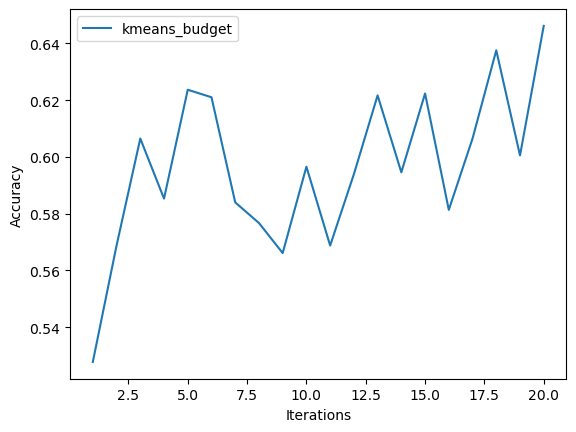

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel

for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [ ]:
accuracy_scores_dict

defaultdict(list,
            {'kmeans_budget': [0.5277777777777778,
              0.5687830687830687,
              0.6064814814814814,
              0.5853174603174602,
              0.6236772486772486,
              0.621031746031746,
              0.583994708994709,
              0.5767195767195767,
              0.566137566137566,
              0.5965608465608465,
              0.5687830687830687,
              0.5939153439153438,
              0.6216931216931216,
              0.5945767195767195,
              0.6223544973544973,
              0.5813492063492063,
              0.6064814814814814,
              0.6375661375661376,
              0.6005291005291005,
              0.6461640211640212]})